<a href="https://colab.research.google.com/github/Roxot/MTM-2025-lab/blob/main/%5BSOLUTIONS%5D_Decoding_Algorithms_Decision_Making_Under_Uncertainty_in_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decoding Algorithms: Decision Making Under Uncertainty in Machine Translation

Machine translation systems are powered by neural networks trained to assign probabilities to possible target-language continuations, given a source-language input. Yet, while models learn to represent a distribution over candidate translations, our practical goal is typically to produce concrete translations. This gap is bridged by *decoding algorithms* — carefully designed procedures that explore the space of outcomes and make concrete decisions under uncertainty.

Decoding algorithms come in different flavors:  
- *Samplers* explore the space of outputs in line with the model’s probability distribution or restricted next-token distributions.  
- *Search methods* attempt to identify the "best" sequence under some specified criterion.  

In this lab, you will:  
1. Implement a number of common samplers and decoding algorithms and examine their fundamental design.  
2. Learn about decision rules that specify an "optimal" translation, focusing on MAP and MBR decoding.  
3. Implement approximations to these two decision rules and assess their quality both as approximations to the target criterion and in terms of translation quality.  

We will be using EuroLLM 1.7B Instruct, a multilingual instruction-tuned model developed as part of the UTTER partnership, to ground these exercises in a real translation system.  

*This lab was developed in the context of the [UTTER Project](https://he-utter.eu/) (Grant Agreement No 101070631).*

## Section 0: Setup


In [1]:
!pip install transformers==4.37.2 datasets==2.16.0 huggingface-hub==0.23.0 accelerate==0.31.0
!pip install sacremoses
!pip install unbabel-comet

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset

import comet
import torch
import torch.nn.functional as F

import logging, warnings
import pytorch_lightning as pl
from transformers import logging as hf_logging

import matplotlib.pyplot as plt
import numpy as np

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
hf_logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=FutureWarning)

pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

### The NMT Model

We will use EuroLLM 1.7B Instruct as our working NMT system, a lightweight multilingual instruction-tuned model introduced in [EuroLLM (Martins et al., 2024)](https://arxiv.org/pdf/2409.16235). To run the following code efficiently, **make sure to select the correct Colab runtime** (GPU or TPU). The snippet below loads the model and tokenizer from Hugging Face Hub, moves the model to the selected device, and sets it to evaluation mode so we can focus on experimenting with samplers and decoding algorithms.

The `ChatTemplate` helper class builds prompts in the format expected by EuroLLM’s chat interface. It wraps Hugging Face’s `apply_chat_template`, allowing us to provide either a single user string or a list of alternating user/assistant turns, with an optional system prompt. The output is a string formatted with this chat template configured for translation. We will set up the chat template with a system instruction to translate all texts to English, feel free to play around with this.

In case no GPU is available, we will use a smaller more traditional translation system `Helsinki-NLP/opus-mt-fi-en` instead. In that case, the `ChatTemplate` class is a just dummy class to retain the same interface.


In [3]:
if torch.cuda.is_available():
    device = "cuda"
    model_id = "utter-project/EuroLLM-1.7B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True
    ).to(device).eval()

    class ChatTemplate:
        def __init__(self, tokenizer, system_prompt=None):
            self.tokenizer = tokenizer
            self.system_prompt = system_prompt

        def __call__(self, x, add_generation_prompt=True, device=None):
            def apply_chat_template(x_i):
                messages = []
                if self.system_prompt: messages.append({"role": "system", "content": self.system_prompt})
                messages.append({"role": "user", "content": x_i})
                return self.tokenizer.apply_chat_template(
                    messages, add_generation_prompt=add_generation_prompt, tokenize=False
                )

            if isinstance(x, str):
                return apply_chat_template(x)
            elif isinstance(x, list):
                conversations = []
                for x_i in x:
                    conversations.append(apply_chat_template(x_i))
                return conversations
            else:
                raise ValueError("Expected string or list.")
else:
    device = "cpu"
    model_id = "Helsinki-NLP/opus-mt-fi-en"
    tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    device = "cpu"
    model = AutoModelForSeq2SeqLM.from_pretrained(
        model_id,
        low_cpu_mem_usage=True
    ).to(device).eval()

    class ChatTemplate:
        def __init__(self, tokenizer, system_prompt=None):
            # dummy class for API compatability
            pass

        def __call__(self, x, add_generation_prompt=True):
            return x

chat_template = ChatTemplate(tokenizer, system_prompt="Translate all user texts to English.")
print(chat_template("Tervetuloa MT Marathon 2025 -tapahtumaan!"))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


<|im_start|>system
Translate all user texts to English.<|im_end|>
<|im_start|>user
Tervetuloa MT Marathon 2025 -tapahtumaan!<|im_end|>
<|im_start|>assistant



## Section 1: Samplers

We begin by implementing a set of common samplers that specify how the next token is chosen given the model’s probability distribution. Each of these methods is wrapped in a simple strategy class, which the `RolloutGenerator` can use to produce sequences token per token. We first implement them very verbosely for a single generation for didactic purposes. We start with the most pure form of sampling: unbiased / ancestral sampling.

$$ y \sim P_\theta(Y|x) $$

$Y$ represents the random variable over responses / generations, $\theta$  are the trained neural network parameters, and $x$ is our source sentence. Note that for our instruction-tuned model, $x$ also includes the chat template and system prompt. From a probabilistic perspective, this does not change anything except for that we have a longer conditioning context.

Generations produced with ancestral sampling follow the conditional distribution imposed by the neural network.In PyTorch we can use a nice helper function `torch.multinomial(.)` to perform the sampling operation for us.

In [4]:
class RolloutGenerator:
    def __init__(self, model, tokenizer, strategy):
        self.model = model
        self.tokenizer = tokenizer
        self.strategy = strategy

    @torch.no_grad()
    def generate(self, input_ids, max_new_tokens=256):
        if getattr(self.model.config, "is_encoder_decoder", False):
            return self._generate_enc_dec(input_ids, max_new_tokens)
        else:
            return self._generate_dec_only(input_ids, max_new_tokens)

    @torch.no_grad()
    def _generate_dec_only(self, x, max_new_tokens):
        """
        EuroLLM uses a decoder only architecture.
        """
        context = self.tokenizer(x, return_tensors="pt")["input_ids"]
        context = context.to(next(self.model.parameters()).device)
        response = []

        for _ in range(max_new_tokens):
            logits = self.model(input_ids=context).logits[0, -1]  # [V]

            # We call strategy for making a decision about the next token
            next_token_id = self.strategy(logits) # int

            response.append(next_token_id)
            context = torch.cat([context,
                                torch.tensor([[next_token_id]], device=context.device)], dim=1)

            if next_token_id == self.tokenizer.eos_token_id:
                break

        return torch.tensor(response, device=context.device)  # [response_length]

    @torch.no_grad()
    def _generate_enc_dec(self, x, max_new_tokens):
        """
        If you're using a CPU and Helsinki-NLP/opus-mt-fi-en, this uses an encoder decoder architecture instead.
        """
        input_ids = self.tokenizer(x, return_tensors="pt")["input_ids"].to(device)
        decoder_input_ids = torch.tensor([[self.model.config.decoder_start_token_id]], device=device)
        response = []
        for _ in range(max_new_tokens):
            logits = self.model(input_ids=input_ids, decoder_input_ids=decoder_input_ids).logits[0, -1]  # [V]

             # We call strategy for making a decision about the next token
            next_token_id = self.strategy(logits)
            response.append(next_token_id)
            decoder_input_ids = torch.cat([decoder_input_ids, torch.tensor([[next_token_id]], device=device)], dim=1)
            if next_token_id == self.tokenizer.eos_token_id:
                break
        return torch.tensor(response, device=device)  # [response_length]

class AncestralSamplingStrategy:

    def __call__(self, logits):  # logits: [V]
        next_token_distribution = F.softmax(logits, dim=-1)
        return torch.multinomial(next_token_distribution, 1)

generator = RolloutGenerator(model, tokenizer, strategy=AncestralSamplingStrategy())
x = chat_template("Tervetuloa MT Marathon 2025 -tapahtumaan!")
nsamples = 3
for i in range(nsamples):
    response_ids = generator.generate(x)
    response = tokenizer.decode(response_ids, skip_special_tokens=True)
    print(f"Sample {i+1}: {response}")

Sample 1: Welcome to the MT Marathon 2025 event!
Sample 2: Welcome to MT Marathon 2025 -event!
Sample 3: Welcome to MT Marathon 2025!


Let's have a look a bit more closely while rolling out these next token distributions and see what the next token distributions look like:

In [5]:
class VerboseAncestralSamplingStrategy:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.prefix_response = []

    def __call__(self, logits):
        next_token_distribution = F.softmax(logits, dim=-1)
        sampled_token_id = torch.multinomial(next_token_distribution, 1)
        sampled_token = self.tokenizer.decode([sampled_token_id.item()])
        print(f"Partial response: {tokenizer.decode(self.prefix_response)}")

        top_probs, top_ids = torch.topk(next_token_distribution, k=5)

        for token_prob, token_id in zip(top_probs, top_ids):
            token_candidate = self.tokenizer.decode([token_id])
            marker = "←" if token_id == sampled_token_id else ""
            print(f"'{token_candidate}'\t\t(p={token_prob:.4f}) {marker}")
        print("...")

        if sampled_token_id not in top_ids:
            token_prob = float(next_token_distribution[sampled_token_id.item()])
            print(f"{sampled_token}\t\t(p={token_prob:.4f}) ←")
        print()

        self.prefix_response.append(sampled_token_id.item())

        return sampled_token_id

x = chat_template("Tervetuloa MT Marathon 2025 -tapahtumaan!")
generator = RolloutGenerator(model, tokenizer, strategy=VerboseAncestralSamplingStrategy(tokenizer))
response_ids = generator.generate(x)
response = tokenizer.decode(response_ids, skip_special_tokens=True)

Partial response: 
'Wel'		(p=0.9367) ←
'Gre'		(p=0.0120) 
'W'		(p=0.0098) 
'Th'		(p=0.0062) 
'We'		(p=0.0049) 
...

Partial response: Wel
'come'		(p=0.9998) ←
'comes'		(p=0.0001) 
'com'		(p=0.0001) 
'coming'		(p=0.0000) 
'kom'		(p=0.0000) 
...

Partial response: Welcome
'to'		(p=0.9741) ←
'MT'		(p=0.0090) 
','		(p=0.0063) 
'back'		(p=0.0019) 
'!'		(p=0.0012) 
...

Partial response: Welcome to
'the'		(p=0.7307) ←
'MT'		(p=0.2525) 
'Marathon'		(p=0.0043) 
''		(p=0.0025) 
'M'		(p=0.0022) 
...

Partial response: Welcome to the
'MT'		(p=0.8164) ←
''		(p=0.1441) 
'Marathon'		(p=0.0239) 
'M'		(p=0.0026) 
'Mt'		(p=0.0016) 
...

Partial response: Welcome to the MT
'Marathon'		(p=0.9723) ←
'Mar'		(p=0.0218) 
''		(p=0.0011) 
'MAR'		(p=0.0009) 
'mar'		(p=0.0006) 
...

Partial response: Welcome to the MT Marathon
''		(p=0.9927) ←
'in'		(p=0.0021) 
'�'		(p=0.0007) 
','		(p=0.0006) 
'event'		(p=0.0005) 
...

Partial response: Welcome to the MT Marathon 
'2'		(p=0.9999) ←
'1'		(p=0.0000) 
'�'		(p=0.00

### Top-k Sampling
As you may have noticed, unbiased / ancestral samples are not always consistently of high quality, as low probability responses may result in poor translations. In an attempt to improve this a number of truncated samplers have been proposed that restrict the support of the next token distributions. Top-k samplings ([Fan et al., 2018](https://aclanthology.org/P18-1082/)) restricts the vocabulary of next token distributions to the $k$ most probable tokens. Borrowing the formulation of [Meister et al.](https://aclanthology.org/2023.tacl-1.7.pdf), we can define the *truncation set* $C_k(t)$ as the solution to the following optimization problem:

\begin{aligned}
    \max_{C_k(t) \in \mathcal{P}(V)} \quad
    & \sum_{y \in C_k(t)} P_\theta(y \mid x, y_{<t}) \\
    \text{subject to} \quad
    & |C_k(t)| \leq k,
\end{aligned}


where $\mathcal{P}$ is the power set operator and $V$ is our vocabulary. The solution to this optimization problem is trivially the $k$ highest probability tokens of the next token distribution. In top-k sampling, we then sample from the conditional distribution:

$$ Y_t^\text{top-k} \sim P_\theta(Y_t=y_t \mid x, y_{<t}, y_t \in C_k(t)). $$

Implement this strategy below.

In [6]:
class TopKSamplingStrategy:

    def __init__(self, k=50):
        self.k = k

    def __call__(self, logits):
        """
        Implement your solution here.
        Hint: you can use torch.topk(.) to easily get the top-k IDs and their corresponding probabilities.
        """
        pass

        ### SOLUTION
        next_token_distribution = F.softmax(logits, dim=-1)
        V = next_token_distribution.size(0)
        k = min(self.k, V)
        topk = torch.topk(next_token_distribution, k, dim=-1)
        renorm = topk.values / topk.values.sum()
        choice = torch.multinomial(renorm, 1).item()
        return topk.indices[choice].item()

k = 50
generator = RolloutGenerator(model, tokenizer, strategy=TopKSamplingStrategy(k=k))
nsamples = 3
for i in range(nsamples):
    response_ids = generator.generate(x)
    response = tokenizer.decode(response_ids, skip_special_tokens=True)
    print(f"Top-k (k={k}) sample {i+1}: {response}")

Top-k (k=50) sample 1: Welcome to the MT Marathon 2025 event!
Top-k (k=50) sample 2: Welcome to the MT Marathon 2025!
Top-k (k=50) sample 3: Welcome to MT Marathon 2025-event!


### Nucleus Sampling
Now we move on to a sampler that adapts the candidate set size flexibly following the shape of the next-token distribution. Nucleus sampling ([Holtzman et al., 2020](https://openreview.net/forum?id=rygGQyrFvH)) defines the truncation set as the solution to the following optimization problem:

\begin{aligned}
    \min_{\mathcal{C}_p(t) \in \mathcal{P}(V)} \quad
    & \lvert \mathcal{C}_t \rvert \\
    \text{subject to} \quad
    & \sum_{y \in \mathcal{C}_p(t)} P_\theta(y \mid x, y_{<t}) \;\geq\; p
\end{aligned}

where we have hyperparameter $p \in (0, 1)$. The solution to this optimization problem is the smallest set of tokens (sorted by probability) whose cumulative mass reaches at least $p$. Then, nucleus sampling samples from the distribution

$$Y_t^{\text{nucleus}} \sim P_\theta(Y_t=y_t \mid x, y_{<t}, \ y_t \in C_p(t)).$$

Implement this strategy below.


In [7]:
class NucleusSamplingStrategy:

    def __init__(self, p=0.9):
        self.p = p

    def __call__(self, logits): # [V]
        """
        Implement your solution here.
        Hint: You can use torch.cumsum(.) to compute cumulative probability mass.
        """
        pass

        ### SOLUTION
        next_token_distribution = F.softmax(logits, dim=-1)
        sorted_probs, sorted_idx = torch.sort(next_token_distribution, descending=True)
        cdf = torch.cumsum(sorted_probs, dim=-1)
        cutoff = torch.searchsorted(cdf, torch.tensor(self.p, device=next_token_distribution.device))
        cutoff = max(cutoff.item(), 1)  # keep at least one
        keep_probs = sorted_probs[:cutoff]
        keep_probs = keep_probs / keep_probs.sum()
        choice_local = torch.multinomial(keep_probs, 1).item()
        return sorted_idx[choice_local].item()

p = 0.9
generator = RolloutGenerator(model, tokenizer, strategy=NucleusSamplingStrategy(p=p))
nsamples = 3
for i in range(nsamples):
    response_ids = generator.generate(x)
    response = tokenizer.decode(response_ids, skip_special_tokens=True)
    print(f"Nucleus (p={p}) sample {i+1}: {response}")

Nucleus (p=0.9) sample 1: Welcome to the MT Marathon 2025 event!
Nucleus (p=0.9) sample 2: Welcome to the MT Marathon 2025!
Nucleus (p=0.9) sample 3: Welcome to the MT Marathon 2025 event!


### Locally Typical Sampling
Finally, we have a look at a perhaps slightly lesser known sampling strategy: locally typical sampling ([Meister et al., 2023](https://aclanthology.org/2023.tacl-1.7.pdf)). Locally typical sampling defines the truncation set as the solution to the optimization problem:

\begin{aligned}
    \min_{\mathcal{C}_\tau(t) \in \mathcal{P}(V)} \quad
    & \sum_{y \in \mathcal{C}_\tau(t)} \Bigl\lvert \, H(Y_t \mid x, y_{<t}, \theta))
      - \log \left(\frac{1}{P_\theta(Y_t = y \mid x, y_{<t})}\right) \, \Bigr\rvert \\
    \text{subject to} \quad
    & \sum_{y \in \mathcal{C}_\tau(t)} P_\theta(Y_t = y \mid x, y_{<t}) \geq \tau,
\end{aligned}

where $H(Y_t\mid x, y_{<t}, \theta)$ is the entropy of the next token distribution.

In practice, the resulting set is the smallest set of tokens sorted by the absolute distance of their *surprisal values* to the entropy, whose cumulative probability mass is at least $\tau$. Surprisal is a concept from information theory that measures how "unexpected" a token $v$ is under the model distribution:

\begin{aligned}
s(y_t \mid x, y_{<t}, \theta) &= \log\left(\frac{1}{P_\theta(Y_t=v|x, y_{<t})}\right) \\
&=  -\log P_\theta(Y_t=v|x, y_{<t})
\end{aligned}

The entropy of the predictive distribution is the expected surprisal:

$$
H(Y_t \mid x, y_{<t}, \theta) = \mathbb{E}_{P_\theta(Y_t \mid x, y_{<t})}[s(y_t \mid x, y_{<t}, \theta)] \, .
$$

Locally typical sampling then selects tokens whose surprisal $s(y \mid y_{<t})$ is within $\tau$ distance to the entropy of the next token distribution.


$$Y_t^{\text{typical}} \sim P_\theta(Y_t=y_t \mid x, y_{<t},\ y_t \in \mathcal{C}_\tau(t)).$$

Note that ${C}_\tau(t)$ does not necessarily include the highest probability tokens.

Implement this strategy below.


In [8]:
class LocallyTypicalSamplingStrategy:

    def __init__(self, tau=0.2):
        self.tau = tau

    def __call__(self, logits): # [V]
        """
        Implement your solution here.
        Hint: Be careful to avoid NaNs when using torch.log(.), add some small constant (e.g. 1e-12) to avoid log(0) or use logsoftmax.
        """
        pass

        ### SOLUTION
        next_token_distribution = F.softmax(logits, dim=-1)
        logp = torch.log(next_token_distribution + 1e-12)
        surprisal = -logp
        H = (next_token_distribution * surprisal).sum()
        dev = torch.abs(surprisal - H)
        order = torch.argsort(dev, dim=-1)  # closest to typical first
        probs_sorted = next_token_distribution[order]
        cdf = torch.cumsum(probs_sorted, dim=-1)
        cutoff = torch.searchsorted(cdf, torch.tensor(self.tau, device=next_token_distribution.device))
        cutoff = max(int(cutoff.item()), 1)
        keep_idx = order[:cutoff]
        keep_probs = next_token_distribution[keep_idx]
        keep_probs = keep_probs / keep_probs.sum()
        choice_local = torch.multinomial(keep_probs, 1).item()
        return keep_idx[choice_local].item()

tau = 0.95
generator = RolloutGenerator(model, tokenizer, strategy=LocallyTypicalSamplingStrategy(tau=tau))
nsamples = 3
for i in range(nsamples):
    response_ids = generator.generate(x)
    response = tokenizer.decode(response_ids, skip_special_tokens=True)
    print(f"Locally Typical (tau={tau}) sample {i+1}: {response}")

Locally Typical (tau=0.95) sample 1: Welcome to the MT Marathon 2025 event!
Locally Typical (tau=0.95) sample 2: Welcome to the MT Marathon 2025 event!
Locally Typical (tau=0.95) sample 3: Welcome to the MT Marathon 2025!


### Batched implementation

So far, you have implemented ancestral sampling, top-$k$, nucleus, and locally typical sampling on a simple one-dimensional example. This is nice for didactic purposes, but usually batched implementations are used for efficiency. This requires your sampling functions to handle inputs of shape `[B, V]` instead of `[V]`, returning one token per batch element.


Below, adapt your ancestral sampling implementation to work for batches as well in `AncestralSamplingStrategyBatched`. Optionally, you may also do this for the other sampling strategies.

In [9]:
class RolloutGeneratorBatched:
    def __init__(self, model, tokenizer, strategy):
        self.model = model
        self.tokenizer = tokenizer
        self.strategy = strategy

    @torch.no_grad()
    def generate(self, x, max_new_tokens=256):
        if getattr(self.model.config, "is_encoder_decoder", False):
            return self._generate_enc_dec(x, max_new_tokens)
        else:
            return self._generate_dec_only(x, max_new_tokens)

    @torch.no_grad()
    def _generate_dec_only(self, x, max_new_tokens):
        device = next(self.model.parameters()).device
        toks = self.tokenizer(x, return_tensors="pt", padding=True)
        context = toks["input_ids"].to(device) # [B, S]
        attn = toks["attention_mask"].to(device) # [B, S]
        response = torch.zeros((context.size(0), 0), dtype=torch.long, device=device)
        B = context.size(0)
        finished = torch.zeros(B, dtype=torch.bool, device=device)

        for _ in range(max_new_tokens):
            logits = self.model(input_ids=context, attention_mask=attn).logits[:, -1] # [B, V]
            next_id = self.strategy(logits) # [B]
            next_id = torch.where(finished, torch.full_like(next_id, self.tokenizer.eos_token_id), next_id)

            context = torch.cat([context, next_id.unsqueeze(-1)], dim=1)
            attn = torch.cat([attn, torch.ones(B, 1, dtype=attn.dtype, device=device)], dim=1)
            response = torch.cat([response, next_id.unsqueeze(-1)], dim=1)

            finished |= (next_id == self.tokenizer.eos_token_id)
            if finished.all(): break

        return response  # [B, T]

    @torch.no_grad()
    def _generate_enc_dec(self, x, max_new_tokens):
        device = next(self.model.parameters()).device
        toks = self.tokenizer(x, return_tensors="pt", padding=True)
        enc = toks["input_ids"].to(device) # [B, S]
        enc_attn = toks["attention_mask"].to(device) # [B, S]
        B = enc.size(0)
        start_id = self.model.config.decoder_start_token_id
        dec = torch.full((B, 1), start_id, dtype=torch.long, device=device)
        response = torch.zeros((B, 0), dtype=torch.long, device=device)
        finished = torch.zeros(B, dtype=torch.bool, device=device)

        for _ in range(max_new_tokens):
            logits = self.model(input_ids=enc, attention_mask=enc_attn,
                                decoder_input_ids=dec).logits[:, -1] # [B, V]
            next_id = self.strategy(logits) # [B]
            next_id = torch.where(finished, torch.full_like(next_id, self.tokenizer.eos_token_id), next_id)

            dec = torch.cat([dec, next_id.unsqueeze(-1)], dim=1)
            response = torch.cat([response, next_id.unsqueeze(-1)], dim=1)

            finished |= (next_id == self.tokenizer.eos_token_id)
            if finished.all(): break

        return response  # [B, T]

class AncestralSamplingStrategyBatched:

    def __call__(self, logits):
        """
        Implement your solution here.
        Hint: you can implement this almost identically to before.
        """
        pass

        ### SOLUTION
        next_token_distribution = torch.softmax(logits, dim=-1)
        next_ids = torch.multinomial(next_token_distribution, 1).squeeze(-1) # [B]
        return next_ids


class TopKSamplingBatched:

    def __init__(self, k=50):
        self.k = k

    def __call__(self, logits):
        """
        (Optional) Implement your solution here.
        """
        pass

        ### SOLUTION
        next_token_distribution = F.softmax(logits, dim=-1) # [B, V]
        B, V = next_token_distribution.size()
        topk = torch.topk(next_token_distribution, self.k)
        renorm = topk.values / topk.values.sum(dim=-1).unsqueeze(-1)
        choice = torch.multinomial(renorm, 1).squeeze() # [B]
        return topk.indices[torch.arange(B), choice]


class NucleusSamplingBatched:

    def __init__(self, p=0.9):
        self.p = p

    def __call__(self, logits):
        """
        (Optional) Implement your solution here.
        """
        pass

        ### SOLUTION
        next_token_distribution = F.softmax(logits, dim=-1) # [B, V]
        sorted_probs, sorted_idx = torch.sort(next_token_distribution, descending=True, dim=-1) # [B, V]
        cdf = torch.cumsum(sorted_probs, dim=-1) # [B, V]
        cutoffs = torch.sum(cdf < self.p, dim=-1) + 1  # [B], ensure >= 1
        choices = []
        for b in range(next_token_distribution.size(0)):
            k = cutoffs[b].item()
            keep_probs = sorted_probs[b, :k]
            keep_probs = keep_probs / keep_probs.sum()
            choice_local = torch.multinomial(keep_probs, 1).item()
            choices.append(sorted_idx[b, choice_local].item())
        return torch.tensor(choices, device=logits.device)

class LocallyTypicalSamplingBatched:

    def __call__(self, logits): # [B, V]
        """
        (Optional) Implement your solution here.
        """
        pass

generator = RolloutGeneratorBatched(model, tokenizer, strategy=TopKSamplingBatched())
x = chat_template(["Tervetuloa MT Marathon 2025 -tapahtumaan!"] * 3)
response_ids = generator.generate(x)
responses = tokenizer.batch_decode(response_ids, skip_special_tokens=True)
for i, response in enumerate(responses):
    print(f"Sample {i+1}: {response}")

Sample 1: Welcome to the MT Marathon 2025 event!
Sample 2: Welcome to the MT Marathon 2025 event!
Sample 3: Welcome to the 2025 MT Marathon!


## Section 2: Maximum-A-Posteriori (MAP)

So far, we have examined various sampling-based decoding strategies. While these can yield fluent and diverse generations, they do not explicitly approximate any particular decision rule. In contrast, **maximum-a-posteriori (MAP)** decoding corresponds to a well-defined decision rule: selecting the single most probable sequence under the model distribution. MAP serves as the implicit principle behind many widely used decoding strategies:

$$
y^{\text{MAP}} = \arg\max_{y \in \mathcal{Y}} P_\theta(Y=y \mid x)
$$

Solving for this optimization problem exactly is intractable, given the unbounded nature of the outcome space. Therefore, approximate decoding algorithms are used to approximate the decision rule.

Greedy decoding is one such simple approximation. Greedy decoding selects the locally highest-probability token at each step, always choosing the most likely continuation given the current context.

Implement this strategy below for both the 1D case and the batched case. Additionally, for the non-batched case, also compute the log probability of the entire sequence, i.e. the log probability that the model assigns to the outcome. As to avoid having to override the RolloutGenerator function, we'll do this a bit hacky by keeping a state in the generation strategy and reading this out after generating. Remember, we factorize this probability as:

$$ P(y|x, \theta) = \prod_{t=1, 2\ldots|y|} P_\theta(y_t|x) $$

In [10]:
class GreedyStrategy:

    log_probs = None

    def get_log_probs(self):
        log_probs = self.log_probs.cpu().numpy()
        self.log_probs = None
        return log_probs

    def __call__(self, logits): # logits: [V]
        """
        Implement your solution here.

        Return the chosen token ID according to the greedy decoding strategy,
        and update the log probability of the sequences in self.log_probs.
        """
        pass

        ### SOLUTION
        logP = F.log_softmax(logits, dim=-1)
        choice = torch.argmax(logP, dim=-1)
        if self.log_probs is None:
            self.log_probs = logP[choice]
        else:
            self.log_probs += logP[choice]
        return choice

class GreedyStrategyBatched:

    def __call__(self, logits): # logits: [B, V]
        """
        Implement your solution here.

        Return the chosen token ID according to the greedy decoding strategy.
        Don't worry about computing log probs here as you are missing some state
        variables to keep track of finished sequences when sequences in the batch
        are different lengths.
        """
        pass

        ### SOLUTION
        return torch.argmax(logits, dim=-1)

# Non-batched, with log probs
x = chat_template(["Tervetuloa MT Marathon 2025 -tapahtumaan!",
                   "Tervetuloa MT Marathon 2025:een, viikon mittaiseen konekäännösteknologian huipputapahtumaan, joka järjestetään 25.–29. elokuuta Helsingin yliopiston kampuksella ydinkeskustassa!"])
greedy_strategy = GreedyStrategy()
generator = RolloutGenerator(model, tokenizer, strategy=greedy_strategy)
for x_i in x:
    response_ids = generator.generate(x_i)
    log_probs = greedy_strategy.get_log_probs()
    response = tokenizer.decode(response_ids, skip_special_tokens=True)
    print(response)
    print(log_probs)

# Batched
generator = RolloutGeneratorBatched(model, tokenizer, strategy=GreedyStrategyBatched())
response_ids = generator.generate(x)
responses = tokenizer.batch_decode(response_ids, skip_special_tokens=True)
print(responses)

Welcome to the MT Marathon 2025 event!
-1.1457158
Welcome to the MT Marathon 2025, a week-long technology summit focused on the latest advancements in machine translation technology, taking place from August 25th to 29th at the Helsinki University campus in the city center!
-16.929296
['Welcome to the MT Marathon 2025 event!', 'Welcome to the MT Marathon 2025, a week-long technology summit focused on the latest advancements in machine translation technology, taking place from August 25th to 29th at the Helsinki University campus in the city center!']


### Beam Search
Beam search approximates MAP decoding by expanding greedy search from 1 path to k paths. At each step, it expands each partial hypothesis with all candidate tokens, scores them by cumulative log-probability (optionally with some length normalization/penalty, which we will not use as we wish to approximate MAP as best as possible), and prunes to the top-k continuations. This breadth-limited search can potentially find higher probability responses than greedy search by keeping multiple promising alternatives in play.

Implementing a correct, batched beam search is fiddly and quite outside of the scope of this lab. Therefore, we just use the `transformers` library its built-in implementation. If you want to study a clean reference implementation, I recommend having a look at [Joey NMT](https://github.com/joeynmt/joeynmt/tree/main). We also return the log probability again, but this time we conveniently get this as an output of the beam search call.

Can you find a higher probability outcome than with greedy decoding by increasing the beam size?

In [11]:
@torch.no_grad()
def beam_search_generate(x, model, tokenizer, beam_size, max_new_tokens=256, return_log_probs=False):
    torch.cuda.empty_cache()
    device = next(model.parameters()).device
    tokens = tokenizer(x, return_tensors="pt", padding=True).to(device)
    padded_input_len = tokens["input_ids"].shape[1]
    out = model.generate(
        **tokens,
        num_beams=beam_size,
        do_sample=False,
        early_stopping=True,
        max_new_tokens=max_new_tokens,
        output_scores=return_log_probs,
        length_penalty=0.0, # disable length penalty enabled by default
        return_dict_in_generate=return_log_probs
    )

    if return_log_probs:
        response_ids = out["sequences"].cpu().numpy()
        log_probs = out["sequences_scores"].cpu().numpy()

        del out.scores
        del out
    else:
        response_ids = out.cpu().numpy()

    # Remove the prompt for decoder-only models
    if not getattr(model.config, "is_encoder_decoder", False):
        response_ids = [rids[padded_input_len:] for rids in response_ids]

    torch.cuda.empty_cache()

    if return_log_probs:
        return response_ids, log_probs

    return response_ids

response_ids, log_probs = beam_search_generate(x, model, tokenizer, beam_size=2, return_log_probs=True)
responses = tokenizer.batch_decode(response_ids, skip_special_tokens=True)
print(responses)
print(log_probs)

['Welcome to the MT Marathon 2025 event!', 'Welcome to the MT Marathon 2025, a week-long event showcasing cutting-edge machine translation technology, taking place from August 25th to 29th at the Helsinki University campus in the city center!']
[ -1.1461412 -12.7595   ]


### FLORES-200 (fi→en)

We now switch from toy examples to real translation data. The code below loads a tiny Finnish→English subset of FLORES-200 (default: `devtest`, first $n$ examples). We also set up some lightweight evaluation using Cometinho.

In [12]:
def load_flores_fi_en_subset(n=25, split="devtest"):
    """
    Load a tiny fi→en subset from FLORES-200.
    """
    cfg = "fin_Latn-eng_Latn"
    dataset = load_dataset("facebook/flores", name=cfg, split=split, trust_remote_code=True)
    if n is not None and n > 0:
        dataset = dataset.select(range(min(n, len(dataset))))

    src = dataset["sentence_fin_Latn"]
    ref = dataset["sentence_eng_Latn"]

    return src, ref

comet_scorer = comet.load_from_checkpoint(comet.download_model("Unbabel/eamt22-cometinho-da"))
def score_translations(src, refs, preds):
    data = [{"src": s, "mt": p, "ref": r} for s, r, p in zip(src, refs, preds)]
    out = comet_scorer.predict(
        data,
        batch_size=32,
        gpus=0
    )
    return out["system_score"] * 100.0

source, references = load_flores_fi_en_subset()
x = chat_template(source[:3])
response_ids = beam_search_generate(x, model, tokenizer, beam_size=5)
predictions = tokenizer.batch_decode(response_ids, skip_special_tokens=True)

for src, ref, pred in zip(source[:3], references[:3], predictions):
    print(f"Source: {src}")
    print(f"Reference: {ref}")
    print(f"Prediction: {pred}")
    print()

score = score_translations(source[:3], references[:3], predictions)
print(f"\nCometinho score: {score:.2f}")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

hparams.yaml:   0%|          | 0.00/548 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

model.ckpt:   0%|          | 0.00/474M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


Generating dev split: 0 examples [00:00, ? examples/s]

Generating devtest split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Source: Meillä on nyt 4 kuukauden ikäisiä hiiriä, jotka olivat ennen diabeetikkoja, mutta eivät ole enää, hän lisäsi.
Reference: "We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.
Prediction: We now have 4-month-old mice that were previously diabetic, but are no longer, he added.

Source: Tohtori Ehud Ur, Dalhousien yliopiston lääketieteen professori Nova Scotian Halifaxissa ja Kanadan diabetesliiton kliinisen ja tiedeosaston puheenjohtaja, varoitti, että tutkimus on vasta varhaisessa vaiheessa.
Reference: Dr. Ehud Ur, professor of medicine at Dalhousie University in Halifax, Nova Scotia and chair of the clinical and scientific division of the Canadian Diabetes Association cautioned that the research is still in its early days.
Prediction: Dr. Ehud Ur, professor of medicine at Dalhousie University in Halifax, Nova Scotia, and president of the Canadian Diabetes Association's clinical and scientific division, warned that the research is at an early s

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Cometinho score: 78.98


### Larger Beam Sizes for Better Approximating MAP

Beam search with a larger beam tends to find translations with higher probability, that thus approximate the MAP objective better. In this exercise experiment with increasing the beam size and study how this affects its approximation to the MAP objective, as well as how this influences translation quality.

In the code cell below, do the following:
- Generate translations with several increasing beam size.
- Compute the *total log-probability* of each translation under the model (conditioned on the prompt).
- Compute the Cometinho score for the predictions, and observe how these change as the beam widens.

Implement your solution below.

In [13]:
average_total_logprob = []  # mean over dataset of total (summed) log-prob
cometinho = []              # system cometinho scores
beam_sizes = [2, 5, 8]

"""
Implement your solution here.
"""

### SOLUTION
batch_size = 4
for beam in beam_sizes:
    print(f"Beam size = {beam}")
    all_preds = []
    all_logps = []

    for i in range(0, len(source), batch_size):
        print(f"{i}, ", end="")
        x = chat_template(source[i : i + batch_size])

        response_ids, batch_logps = beam_search_generate(
            x, model, tokenizer, beam_size=beam, return_log_probs=True
        )

        batch_preds = tokenizer.batch_decode(response_ids, skip_special_tokens=True)
        all_preds.extend(batch_preds)
        all_logps.extend(batch_logps.tolist())

    score = score_translations(source, references, all_preds)
    cometinho.append(score)
    average_total_logprob.append(np.mean(all_logps))

Beam size = 2
0, 4, 8, 12, 16, 20, 24, 

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Beam size = 5
0, 4, 8, 12, 16, 20, 24, 

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Beam size = 8
0, 4, 8, 12, 16, 20, 24, 

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Let's plot the system Cometinho score and average log probability as a function of beam size. If all went well, we should expect to see our approximation to the MAP objective get better for larger beam sizes. Cometinho scores, however, do not necessarily need to follow these. In fact, for larger beam sizes they often do not ("The Beam Search Curse", [Koehn and Knowles, 2017](https://aclanthology.org/W17-3204.pdf)).

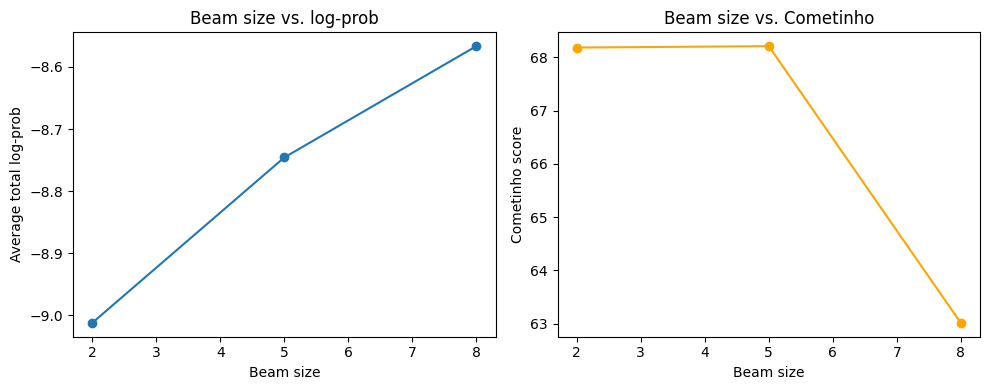

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ax.plot(beam_sizes, average_total_logprob, marker="o")
ax.set_xlabel("Beam size")
ax.set_ylabel("Average total log-prob")
ax.set_title("Beam size vs. log-prob")

ax = axes[1]
ax.plot(beam_sizes, cometinho, marker="o", color="orange")
ax.set_xlabel("Beam size")
ax.set_ylabel("Cometinho score")
ax.set_title("Beam size vs. Cometinho")

plt.tight_layout()
plt.show()

## Section 3: Minimum Bayes Risk (MBR) decoding

As you may have found, MAP as a decision rule does not necessarily result in maximum translation quality. Often, beam search is restricted to use a small beam size of 4 or 5 in order to avoid the aforementioned beam search curse. Therefore, some people have started to look into an alternative decision rule in minimum Bayes risk (MBR). MBR prescribes that the optimal decision from a trained model $P_\theta(Y|x)$ is:

$$
y_{\text{MBR}}
= \arg\max_{y \in \mathcal{Y}}
 \mathbb{E}_{P_\theta(Y \mid x)}[u(y, Y)].
$$

Here, $u(\cdot)$ is a *utility function*: some function that measures the benefit $u(c, r)$ in selecting a candiate $c$ given some reference translation $r$. As you may recognize, the automatic evaluation metrics used in machine translation evaluation (e.g. BLEURT, COMET, etc.) could be used as such a utility function, as long as they function reliably on a sequence level. Of course, at decoding time we do not have access to any actual references. Therefore, the distribution predicted by the machine translation model is used to "fill in" this reference probabilistically in the form of an expectation. The MBR solution is then the one translation / candidate in the support of our machine translation model that maximizes *expected utility*.


### Approximating MBR

Like MAP, computing the MBR solution exactly is typically intractable. Machine translations have an unbounded support over translations and even when restricting length, the size of the support grows exponentially with sequence length. In fact, there are two approximations to be made: *i)* the $\arg\max$ is performed over the entire support of the model and therefore needs to be restricted to a smaller set of candidates, and $ii)$ the expectation again would require an enumaration over the entire support, but we can obtain an unbiased estimate of it using a Monte Carlo approximation.

In this exercise, we will implement MBR decoding. We suggest using the sampling-based approximation employed in [Eikema & Aziz (2020)](https://aclanthology.org/2020.coling-main.398.pdf):

1. **Sample translations**  
   Draw $k$ samples $S = \{y^{(k)}\}_{k=1}^K \sim P_\theta(Y \mid x)$ via ancestral sampling.

2. **Candidate set**  
   Use $C = S$ as the set of candidates as well to approximate the $\arg\max$.

3. **Monte Carlo estimate of expected utility**
For each candidate $c$, perform an MC estimate of its expected utility using $S$ as:
$$
\mathbb{E}_{P_\theta(Y \mid x)}[u(c, Y)] \approx \frac{1}{k}\sum_{k=1}^K u(c, y^{(k)}).
$$
You can save a utility computation by omitting the utility comparison of a candidate with itself.

Now implement MBR decoding by implementing the following three functions:

- `estimate_candidate_set`: approximate the $\arg\max$.
- `estimate_expected_utility`: approximate expected utility using an MC estimate.
- `mbr_generate`: put everything together.

As a utility function, you can use the Cometinho implementation we provide below.

In [15]:
class MBRGenerator:

    def __init__(self, generator, tokenizer):
        self.generator = generator
        self.tokenizer = tokenizer
        self.comet_scorer = comet.load_from_checkpoint(comet.download_model("Unbabel/eamt22-cometinho-da"))

    def _utility_fn(self, src, refs, preds):
        # Return one score per (src, ref, pred) triple (vector output).
        data = [{"src": s, "mt": p, "ref": r} for s, r, p in zip(src, refs, preds)]
        out = self.comet_scorer.predict(data, batch_size=32, gpus=1 if torch.cuda.is_available() else 0)
        scores = torch.tensor(out["scores"], dtype=torch.float32)
        return scores * 100.0

    @torch.no_grad()
    def generate(self, src_sentences, x, k=5, return_expected_utility=False):
        assert k >= 2
        candidate_ids = self.estimate_candidate_set(x, k)
        expected_utilities = self.estimate_expected_utility(src_sentences, candidate_ids)

        """
        Your implementation here

        Note: Cometinho will need the source sentences untouched by the chat template. Hence,
        we pass them separately as src_sentences here.
        """
        pass

        ### SOLUTION
        # mbr_generations = candidate_ids[np.argmax(expected_utilities), 1]
        # print(mbr_generations.size())
        B = expected_utilities.size(0)
        mbr_ids = expected_utilities.argmax(-1)
        mbr_generations = candidate_ids[torch.arange(B), mbr_ids].cpu().numpy()
        E_U = expected_utilities[torch.arange(B), mbr_ids].cpu().numpy()

        if return_expected_utility:
            return mbr_generations, E_U
        return mbr_generations

    def estimate_candidate_set(self, x, k, max_sequence_length=256):
        """
        Your implementation here
        """
        pass

        ### SOLUTION
        candidates = None
        for _ in range(k):
            sample_ids = generator.generate(x).unsqueeze(1)
            sample_ids = F.pad(sample_ids, (0, max_sequence_length - sample_ids.size(-1)),
                               value=self.tokenizer.pad_token_id)
            if candidates is None:
                candidates = sample_ids.cpu()
            else:
                candidates = torch.cat([candidates, sample_ids.cpu()], dim=1)
        return candidates # [B, k, L]

    def estimate_expected_utility(self, src_sentences, candidate_ids):
        """
        Your implementation here
        """
        pass

        ### SOLUTION
        B, k, L = candidate_ids.size()
        U = torch.zeros((B, k, k - 1), dtype=torch.float32)
        for b in range(B):
            candidates = self.tokenizer.batch_decode(candidate_ids[b], skip_special_tokens=True)
            for i in range(k):
                refs = candidates[:i] + candidates[i+1:]  # k-1 refs
                preds = [candidates[i]] * (k - 1)         # candidate repeated
                src  = [src_sentences[b]] * (k - 1)       # source repeated
                u_i  = self._utility_fn(src, refs, preds) # [k-1], torch tensor
                U[b, i] = u_i
        return U.mean(dim=-1) # [B, k]

generator = RolloutGeneratorBatched(model, tokenizer, strategy=AncestralSamplingStrategyBatched())
mbr_generator = MBRGenerator(generator, tokenizer)
src_sentences = ["Tervetuloa MT Marathon 2025 -tapahtumaan!",
                 "Tervetuloa MT Marathon 2025:een, viikon mittaiseen konekäännösteknologian huipputapahtumaan, joka järjestetään 25.–29. elokuuta Helsingin yliopiston kampuksella ydinkeskustassa!"]
x = chat_template(src_sentences)
response_ids = mbr_generator.generate(src_sentences, x, k=5)
responses = tokenizer.batch_decode(response_ids, skip_special_tokens=True)
print("\n")
for i, response in enumerate(responses):
    print(f"Input {i+1}: {response}")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.62it/s]




Input 1: Welcome to MT Marathon 2025 - event!
Input 2: Welcome to MT Marathon 2025, the one-week long, technological breakthrough event in machine translation technology, which will be held on 25 - 29 August at the Helsinki University campus in the city center!



Now let's also see how our hyperparameter $k$, the sample size, improves our estimates of the MBR decision rule, and how this affects translation quality. Implement the code snippet below to fill the `average_expected_utility` and `cometinho` arrays for the various sample sizes. You may find that this will take a bit of time. Feel free to shrink down the dataset size further or use smaller sample sizes.

In [ ]:
average_expected_utility = []  # mean over dataset of expected utility
cometinho = [] # system cometinho scores
sample_sizes = [2, 4, 8, 12]

"""
Implement your solution here.
"""

### SOLUTION
batch_size = 8
for k in sample_sizes:
    torch.cuda.empty_cache()
    print(f"Sample size = {k}")
    all_preds = []
    all_expected_utilities = []

    for i in range(0, len(source), batch_size):
        print(f"{i}, ", end="")
        src_sentences = source[i : i + batch_size]
        x = chat_template(src_sentences)

        response_ids, batch_expected_utilities = mbr_generator.generate(src_sentences, x, k=k, return_expected_utility=True)

        batch_preds = tokenizer.batch_decode(response_ids, skip_special_tokens=True)
        all_preds.extend(batch_preds)
        all_expected_utilities.extend(batch_expected_utilities.tolist())

    score = score_translations(source, references, all_preds)
    cometinho.append(score)
    average_expected_utility.append(np.mean(all_expected_utilities))

Sample size = 2
0, 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.33it/s]


8, 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.64it/s]


16, 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.37it/s]


24, 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.59it/s]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Sample size = 4
0, 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.87it/s]


8, 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.28it/s]


16, 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.09it/s]


24, 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.00it/s]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Sample size = 8
0, 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.53it/s]


8, 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.30it/s]


16, 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.87it/s]


And, finally, we also plot our approximation quality of sample size in this sampling-based MBR algorithm to the MBR objective, as well as Cometinho scores. Do you find that increasing sample size improves our estimates of the MBR objective? What about translation quality?

Optionally, you can experiment with different strategies for `estimate_candidate_set` that use something else than ancestral samples to approximate the $\arg\max$.

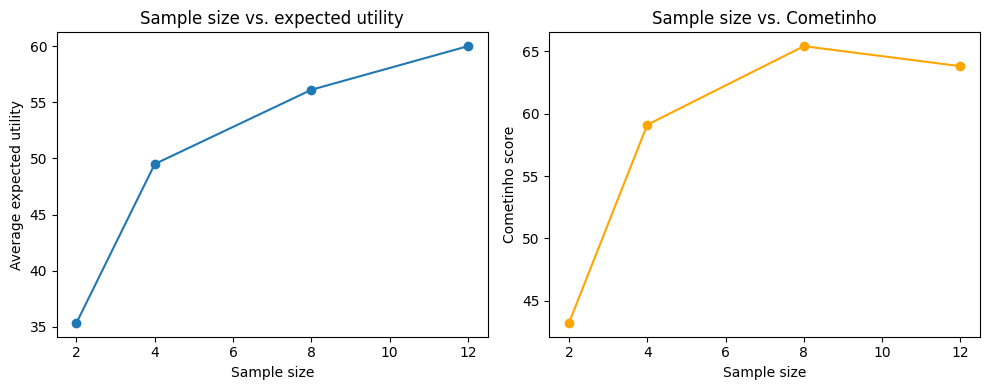

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
ax.plot(sample_sizes, average_expected_utility, marker="o")
ax.set_xlabel("Sample size")
ax.set_ylabel("Average expected utility")
ax.set_title("Sample size vs. expected utility")

ax = axes[1]
ax.plot(sample_sizes, cometinho, marker="o", color="orange")
ax.set_xlabel("Sample size")
ax.set_ylabel("Cometinho score")
ax.set_title("Sample size vs. Cometinho")

plt.tight_layout()
plt.show()